In [1]:
import numpy as np
import time
import tensorflow as tf
import keras
from keras.engine.input_layer import Input
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import random, os, sys
from keras.models import *
from keras.layers import *
from keras import layers,models
import pandas as pd
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

In [2]:
arg={}
arg['dataset_name']='highd'
arg['root_path']='E:/STMF-IE/data'
arg['input_path']=os.path.join(arg['root_path'],arg['dataset_name'],'SS_traindata.npy')
arg['label_path']=os.path.join(arg['root_path'],arg['dataset_name'],'train_traj_label.npy')
arg['learning_rate']=0.0005
arg['lc_label_path']=os.path.join(arg['root_path'],arg['dataset_name'],'onehot_train_lc_label.npy')
arg['lt_label_path']=os.path.join(arg['root_path'],arg['dataset_name'],'onehot_train_longitudinal_label.npy')
arg['adjacen_path']=os.path.join(arg['root_path'],arg['dataset_name'],'adjacency_matrix_traindata.npy')
arg['input_length']=15
arg['output_length']=25
arg['fea_num']=26
arg['use_spatial']=True
arg['use_temporal']=True
arg['use_intention']=True
arg['use_lat_intention']=True
arg['use_lon_intention']=True
arg['use_attention_mask']=True
arg['use_APReLU']=True
arg['ablation_study']=False
if arg['use_spatial'] and arg['use_temporal'] and arg['use_intention'] and arg['use_attention_mask'] and arg['use_APReLU']:
    arg['modelsave_path']=os.path.join(arg['root_path'],arg['dataset_name'],'model.h5')
    arg['resultsave_path']=os.path.join(arg['root_path'],arg['dataset_name'],'rmse.csv')
elif not arg['use_spatial']:
    arg['modelsave_path']=os.path.join(arg['root_path'],arg['dataset_name'],'no_use_spatial_model.h5')
    arg['resultsave_path']=os.path.join(arg['root_path'],arg['dataset_name'],'no_use_spatial.csv')    
elif not arg['use_temporal']:
    arg['modelsave_path']=os.path.join(arg['root_path'],arg['dataset_name'],'no_use_temporal_model.h5')
    arg['resultsave_path']=os.path.join(arg['root_path'],arg['dataset_name'],'no_use_temporal.csv')        
elif not arg['use_intention']:
    arg['modelsave_path']=os.path.join(arg['root_path'],arg['dataset_name'],'no_use_intention_model.h5')
    arg['resultsave_path']=os.path.join(arg['root_path'],arg['dataset_name'],'no_use_intention.csv')         
elif not arg['use_attention_mask']:
    arg['modelsave_path']=os.path.join(arg['root_path'],arg['dataset_name'],'no_use_attention_mask_model.h5')
    arg['resultsave_path']=os.path.join(arg['root_path'],arg['dataset_name'],'no_use_attention_mask.csv')        
elif not arg['use_APReLU']:
    arg['modelsave_path']=os.path.join(arg['root_path'],arg['dataset_name'],'no_use_APReLU_model.h5')
    arg['resultsave_path']=os.path.join(arg['root_path'],arg['dataset_name'],'no_use_APReLU.csv')             
num_heads=8
value_dim=key_dim=64
d_model=num_heads*key_dim
traindata = np.load(arg['input_path'])
adjacen_traindata=np.load(arg['adjacen_path'])
trainlabel = np.load(arg['label_path'])
y_train = trainlabel
lc_trainlabel = np.load(arg['lc_label_path'])
lt_trainlabel =np.load(arg['lt_label_path'])

In [3]:
from keras.regularizers import l2
def cal_mean(inputs):
    outputs = K.mean(inputs, axis=1, keepdims=True)
    return outputs
def aprelu(inputs):
    # get the number of channels
    channels = inputs.get_shape().as_list()[-1]
    # get a zero feature map
    zeros_input = keras.layers.subtract([inputs, inputs])
    # get a feature map with only positive features
    pos_input = Activation('relu')(inputs)
    # get a feature map with only negative features
    neg_input = Minimum()([inputs,zeros_input])
    # define a network to obtain the scaling coefficients
    scales_p = Lambda(cal_mean)(GlobalAveragePooling1D()(pos_input))
    scales_n = Lambda(cal_mean)(GlobalAveragePooling1D()(neg_input))
    scales = Concatenate()([scales_n, scales_p])
    scales = Dense(2, activation='linear', kernel_initializer='he_normal', kernel_regularizer=l2(1e-4))(scales)
    scales = BatchNormalization(momentum=0.9, gamma_regularizer=l2(1e-4))(scales)
    scales = Activation('relu')(scales)
    scales = Dense(1, activation='linear', kernel_initializer='he_normal', kernel_regularizer=l2(1e-4))(scales)
    scales = BatchNormalization(momentum=0.9, gamma_regularizer=l2(1e-4))(scales)
    scales = Activation('sigmoid')(scales)
    scales = Reshape((1,1,1))(scales)
    # apply a paramtetric relu
    neg_part = keras.layers.multiply([scales, neg_input])
    return keras.layers.add([pos_input, neg_part])
def maskedMSE(y_gt,y_pred):
    muX = y_pred[:, :, 0]
    muY = y_pred[:, :, 1]
    x = y_gt[:, :, 0]
    y = y_gt[:, :, 1]
    out = tf.math.pow(x - muX, 2) + tf.math.pow(y - muY, 2)
    return tf.math.reduce_mean(out)
def outputActivation(x,name=''):
    muX = x[:, :, 0:1]
    muY = x[:, :, 1:2]
    sigX = x[:, :, 2:3]
    sigY = x[:, :, 3:4]
    rho = x[:, :, 4:5]
    sigX = tf.math.exp(sigX)  # This positive value represents Reciprocal of SIGMA (1/sigX)
    sigY = tf.math.exp(sigY)
    rho = tf.math.tanh(rho)   # -1 < rho < 1
    out = tf.concat([muX, muY, sigX, sigY, rho], axis=2,name='trajectory_out')
    return out
def maskedNLL(y_gt,y_pred):
    muX = y_pred[:, :, 0]
    muY = y_pred[:, :, 1]
    sigX = y_pred[:, :, 2]
    sigY = y_pred[:, :, 3]
    rho = y_pred[:, :, 4]
    ohr = tf.math.pow(1 - tf.math.pow(rho, 2), -0.5)
    x = y_gt[:, :, 0]
    y = y_gt[:, :, 1]
    #meter
    out = 0.5 * tf.math.pow(ohr, 2) * (tf.math.pow(sigX, 2) * tf.math.pow(x - muX, 2) + tf.math.pow(sigY, 2) * tf.math.pow(y - muY, 2) - 2 * rho *
        tf.math.pow(sigX, 1) * tf.math.pow(sigY, 1) * (x - muX) * (y - muY)) - tf.math.log(sigX * sigY * ohr) +1.8379- 0.5160
    return out
        
def STMF_IEmodel():
        i = Input(shape = (arg['input_length'],arg['fea_num']),name='md_1')
        m = Input(shape = (arg['input_length'],3,3),name='attention_mask_matrics') 
        if arg['use_attention_mask']:
            AM=tf.keras.layers.Reshape((arg['input_length'],9))(m)
            AM= tf.keras.layers.Conv1D(16, 1)(AM)
            AM= tf.keras.layers.Conv1D(32, 1)(AM)
        env= i[:,:,6:21]
        pos= i[:,:,0:6] 
        neibors=i[:,:,21:26]
        #spatial attention
        if arg['use_spatial']:
            state=tf.keras.layers.Reshape((6,arg['input_length']))(pos) #6*15
            neibors_state=tf.keras.layers.Reshape((5,arg['input_length']))(neibors) #5*15
            #s_weights 
            spatial_attention,s_weights=tf.keras.layers.MultiHeadAttention(num_heads, key_dim,dropout=0.1)(state,neibors_state,return_attention_scores=True)
            spatial_attention= tf.keras.layers.Reshape((arg['input_length'],6),name='spatial_attention')(spatial_attention)
            spatial_attention=Add()([pos,spatial_attention])
        ##motion Encoder
        temporal_enc = Dense(32,activation='relu')(pos)
        temporal_enc = LSTM(64, return_sequences=True,
                        return_state=False)(temporal_enc)
        env_enc = Dense(32,activation='relu')(env)
        env_enc = LSTM(64, return_sequences=True,
                        return_state=False)(env_enc)
        f_temporal=tf.keras.layers.Concatenate()([temporal_enc,env_enc])
        if arg['use_temporal']:
            if arg['use_APReLU']:
                f_temporal=tf.squeeze(aprelu(f_temporal),axis=1)
            temporal_attention,temporal_weights=tf.keras.layers.MultiHeadAttention(num_heads, 
                    key_dim,dropout=0.1)(f_temporal,f_temporal,return_attention_scores=True)#
            temporal_attention=Add()([f_temporal,temporal_attention])# b t 64 
        ##fusion
        if arg['use_spatial'] and arg['use_temporal'] and arg['use_attention_mask']:
            temporal_attention_1=Conv1D(128,1)(temporal_attention)
            temporal_attention_2=Conv1D(128,1)(temporal_attention)
            temporal_attention_2=tf.nn.softmax(temporal_attention_2,axis=-1)
            temporal_attention=tf.multiply(temporal_attention,tf.math.sigmoid(tf.multiply(temporal_attention_1,temporal_attention_2)))
            spatial_attention_1=Conv1D(6,1)(spatial_attention)
            spatial_attention_2=Conv1D(6,1)(spatial_attention)
            spatial_attention_2=tf.nn.softmax(spatial_attention_2,axis=-1)
            spatial_attention=tf.multiply(spatial_attention,tf.math.sigmoid(tf.multiply(spatial_attention_1,spatial_attention_2)))
            enc=tf.keras.layers.Concatenate(axis=-1)([temporal_attention,spatial_attention,AM]) #b t 128+6+32
        if not arg['use_spatial']:
            enc=tf.keras.layers.Concatenate(axis=-1)([temporal_attention,AM])
        if not arg['use_temporal']:
            enc=tf.keras.layers.Concatenate(axis=-1)([spatial_attention,AM])
        if not arg['use_attention_mask']:
            temporal_attention_1=Conv1D(128,1)(temporal_attention)
            temporal_attention_2=Conv1D(128,1)(temporal_attention)
            temporal_attention_2=tf.nn.softmax(temporal_attention_2,axis=-1)
            temporal_attention=tf.multiply(temporal_attention,tf.math.sigmoid(tf.multiply(temporal_attention_1,temporal_attention_2)))
            spatial_attention_1=Conv1D(6,1)(spatial_attention)
            spatial_attention_2=Conv1D(6,1)(spatial_attention)
            spatial_attention_2=tf.nn.softmax(spatial_attention_2,axis=-1)
            spatial_attention=tf.multiply(spatial_attention,tf.math.sigmoid(tf.multiply(spatial_attention_1,spatial_attention_2)))
            enc=tf.keras.layers.Concatenate(axis=-1)([temporal_attention,spatial_attention])
        if arg['use_intention']:
            lat_x=Conv1D(filters=32,kernel_size=1)(enc)
            lat_x=BatchNormalization()(lat_x)
            lat_x=GELU()(lat_x)
            lat_x=Conv1D(filters=64,kernel_size=1)(lat_x)
            lat_x=Flatten()(lat_x)
            lat_x=Dense(64,activation='tanh')(lat_x)
            lat_enc=Dense(3,activation='softmax',name="lc_class_output")(lat_x)
            lot_enc=Dense(3,activation='softmax',name="lt_class_output")(lat_x)
            lat_maneuver = tf.keras.layers.RepeatVector(arg['input_length'])(lat_enc)
            lot_maneuver = tf.keras.layers.RepeatVector(arg['input_length'])(lot_enc)
            f_intention=tf.keras.layers.Concatenate(axis=-1)([lat_maneuver,lot_maneuver])
            f_intention=Dense(64,activation='relu')(f_intention)
            enc=tf.keras.layers.Concatenate(axis=-1)([enc,f_intention])
            enc,enc_weight=tf.keras.layers.MultiHeadAttention(num_heads, key_dim,dropout=0.1)(enc,enc,return_attention_scores=True)
        dec=Dense(arg['output_length'])(enc) #30*25
        dec = Permute((2, 1))(dec)
        dec = Dense(5)(dec)
        y=outputActivation(dec)
        if arg['use_intention']:
            return Model(inputs = [i,m], outputs = [y,lat_enc,lot_enc])
        else:
            return Model(inputs = [i,m], outputs = [y])
class GELU(layers.Layer):
    def __init__(self):
        super(GELU, self).__init__()
    def call(self, x):
        cdf = 0.5 * (1.0 + tf.tanh((np.sqrt(2 / np.pi) * (x + 0.044715 * tf.pow(x, 3)))))
        return x * cdf
model =STMF_IEmodel()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
md_1 (InputLayer)               [(None, 15, 26)]     0                                            
__________________________________________________________________________________________________
tf.__operators__.getitem_1 (Sli (None, 15, 6)        0           md_1[0][0]                       
__________________________________________________________________________________________________
tf.__operators__.getitem (Slici (None, 15, 15)       0           md_1[0][0]                       
__________________________________________________________________________________________________
dense (Dense)                   (None, 15, 32)       224         tf.__operators__.getitem_1[0][0] 
______________________________________________________________________________________________

In [4]:
model.load_weights(arg['modelsave_path'])
testdata = np.load('E:/STIL-IE/data/highd/SS_testdata.npy')
adjacen_testdata=np.load('E:/STIL-IE/data/highd/adjacency_matrix_testdata.npy')
traj_testlabel=np.load('E:/STIL-IE/data/highd/test_traj_label.npy')
lc_testlabel=np.load('E:/STIL-IE/data/highd/onehot_test_lc_label.npy')
ori_testdata=np.load('E:/STIL-IE/data/highd/testdata.npy')
lt_testlabel=np.load('E:/STIL-IE/data/highd/onehot_test_longitudinal_label.npy')
if arg['use_intention']:
    pre,lat_pred,lon_pred=model.predict([testdata,adjacen_testdata])
else:
    pre=model.predict([testdata,adjacen_testdata])
end =  time.perf_counter()  

# RMSE

In [5]:
def RMSE(y_gt,y_pred,F):
    muX = y_pred[:, 0:F, 0]
    muY = y_pred[:, 0:F, 1]
    sigX = y_pred[:, 0:F, 2]
    sigY = y_pred[:, 0:F, 3]
    x = y_gt[:, 0:F, 0]
    y = y_gt[:, 0:F, 1]
    mu_out = np.sum(np.sqrt(np.square(muX-x) + np.square(muY-y))/(y_gt.shape[0]),axis=0)
    return mu_out[4::5]

def lat_rmse(y_gt,y_pred,F):
    muX = y_pred[:, 0:F, 0]
    x = y_gt[:, 0:F, 0]
    out = np.sum(np.sqrt(np.square(muX-x))/(y_gt.shape[0]),axis=0)
    return out[4::5]
def lon_rmse(y_gt,y_pred,F):
    muY = y_pred[:, 0:F, 1]
    y = y_gt[:, 0:F, 1]
    out = np.sum(np.sqrt(np.square(muY-y))/(y_gt.shape[0]),axis=0)
    return out[4::5]
results_rmse=[]
results_rmse_lat=[]
results_rmse_lon=[]
F=25
results_rmse.append(RMSE(traj_testlabel,pre,F))  
results_rmse_lat.append(lat_rmse(traj_testlabel,pre,F))   
results_rmse_lon.append(lon_rmse(traj_testlabel,pre,F))
print('rmse:%s'%results_rmse) 
print('rmse:%s'%results_rmse_lat) 
print('rmse:%s'%results_rmse_lon)

rmse:[array([0.04143905, 0.08145516, 0.12359389, 0.33057229, 0.62616545])]
rmse:[array([0.00469432, 0.0108197 , 0.02037139, 0.05621578, 0.1183058 ])]
rmse:[array([0.04065018, 0.07921377, 0.11850093, 0.31679169, 0.59206968])]


# Different lane change

In [6]:
RLC_testdata=testdata[0:209]
RLC_adjacen_testdata=adjacen_testdata[0:209]
RLC_traj_testlabel=traj_testlabel[0:209]


LLC_testdata=testdata[209:418]
LLC_adjacen_testdata=adjacen_testdata[209:418]
LLC_traj_testlabel=traj_testlabel[209:418]

LK_testdata=testdata[418:627]
LK_adjacen_testdata=adjacen_testdata[418:627]
LK_traj_testlabel=traj_testlabel[418:627]

RLC_pre,RLC_lat_pred,RLC_lon_pred=model.predict([RLC_testdata,RLC_adjacen_testdata])
LLC_pre,LLC_lat_pred,LLC_lon_pred=model.predict([LLC_testdata,LLC_adjacen_testdata])    
LK_pre,LK_lat_pred,LK_lon_pred=model.predict([LK_testdata,LK_adjacen_testdata])
def RMSE(y_gt,y_pred,F):
    muX = y_pred[:, 0:F, 0]
    muY = y_pred[:, 0:F, 1]
    sigX = y_pred[:, 0:F, 2]
    sigY = y_pred[:, 0:F, 3]
    x = y_gt[:, 0:F, 0]
    y = y_gt[:, 0:F, 1]
    mu_out = np.sum(np.sqrt(np.square(muX-x) + np.square(muY-y))/(y_gt.shape[0]),axis=0)
    return mu_out[4::5]

def lat_rmse(y_gt,y_pred,F):
    muX = y_pred[:, 0:F, 0]
    x = y_gt[:, 0:F, 0]
    out = np.sum(np.sqrt(np.square(muX-x))/(y_gt.shape[0]),axis=0)
    return out[4::5]
def lon_rmse(y_gt,y_pred,F):
    muY = y_pred[:, 0:F, 1]
    y = y_gt[:, 0:F, 1]
    out = np.sum(np.sqrt(np.square(muY-y))/(y_gt.shape[0]),axis=0)
    return out[4::5]
results_rmse_RLC=[]
results_rmse_LLC=[]
results_rmse_LK=[]
F=25
results_rmse_RLC.append(RMSE(RLC_traj_testlabel,RLC_pre,F))  
results_rmse_LLC.append(RMSE(LLC_traj_testlabel,LLC_pre,F))   
results_rmse_LK.append(RMSE(LK_traj_testlabel,LK_pre,F))
print('RLC_rmse:%s'%results_rmse_RLC) 
print('LLC_rmse:%s'%results_rmse_LLC) 
print('lk_rmse:%s'%results_rmse_LK)

RLC_rmse:[array([0.04459941, 0.09492368, 0.13196708, 0.32253912, 0.61835807])]
LLC_rmse:[array([0.04217464, 0.07435062, 0.1243144 , 0.42144862, 0.81960368])]
lk_rmse:[array([0.03753864, 0.07510055, 0.11440951, 0.24765037, 0.44055359])]


# Rmse all samples

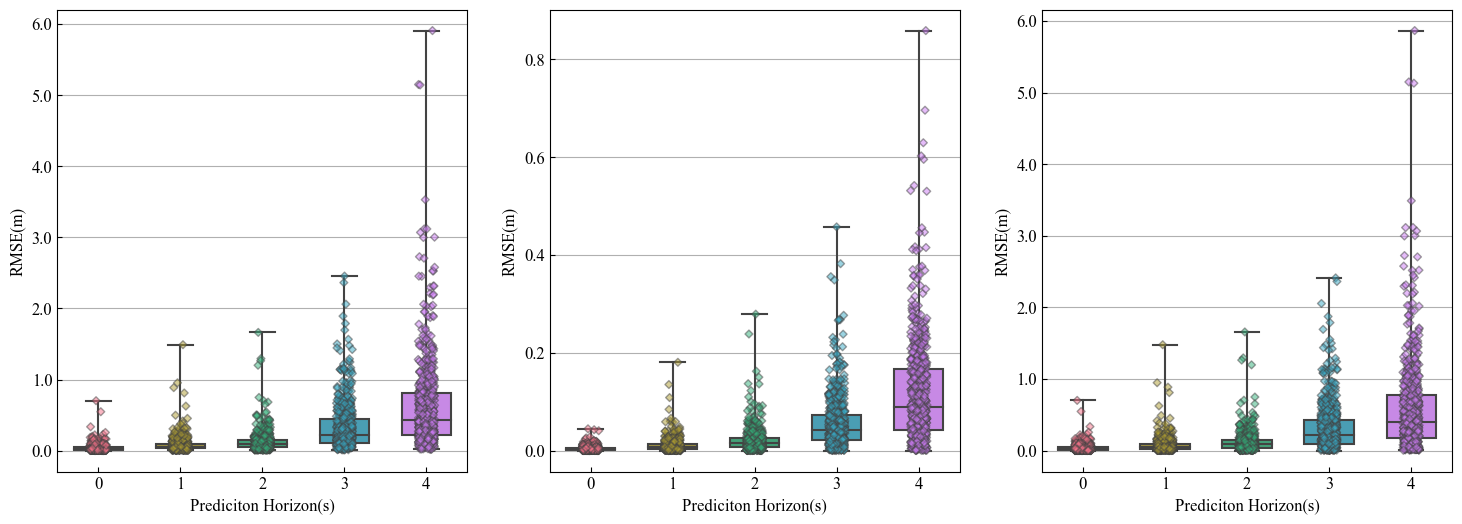

In [10]:
def RMSE(y_gt,y_pred,F):
    muX = y_pred[0:F, 0]
    muY = y_pred[0:F, 1]
    sigX = y_pred[0:F, 2]
    sigY = y_pred[0:F, 3]
    x = y_gt[0:F, 0]
    y = y_gt[0:F, 1]
    mu_out = np.sqrt(np.square(muX-x) + np.square(muY-y))
    return mu_out[4::5]

def lat_rmse(y_gt,y_pred,F):
    muX = y_pred[0:F, 0]
    x = y_gt[0:F, 0]
    out = np.sqrt(np.square(muX-x))
    return out[4::5]
def lon_rmse(y_gt,y_pred,F):
    muY = y_pred[0:F, 1]
    y = y_gt[0:F, 1]
    out = np.sqrt(np.square(muY-y))
    return out[4::5]
F=25
results_rmse=np.zeros((pre.shape[0],F//5))
results_rmse_lat=np.zeros((pre.shape[0],F//5))
results_rmse_lon=np.zeros((pre.shape[0],F//5))
for i in range(pre.shape[0]):
    results_rmse[i]=RMSE(traj_testlabel[i],pre[i],F)
    results_rmse_lat[i]=lat_rmse(traj_testlabel[i],pre[i],F)
    results_rmse_lon[i]=lon_rmse(traj_testlabel[i],pre[i],F)
from matplotlib.ticker import FormatStrFormatter
font_size=12
scales=0.3048
config_traj = {
    "font.family":'serif',
    "font.size": font_size,
    "mathtext.fontset":'stix',
    "font.serif": ['Times New Roman'],
    'xtick.direction':'in',
    'ytick.direction':'in'
}
plt.rcParams.update(config_traj)
fig,ax=plt.subplots(1, 3,figsize=(18, 6))
sns.boxplot(data=results_rmse,
            whis=[0, 100], width=.6,palette='husl',ax=ax[0])
sns.stripplot(data=results_rmse,
              size=4, color=".5", linewidth=1,alpha=.5,marker="D",ax=ax[0],palette='husl')
sns.boxplot(data=results_rmse_lat,
            whis=[0, 100], width=.6,palette='husl',ax=ax[1])
sns.stripplot(data=results_rmse_lat,
              size=4, color=".5", linewidth=1,alpha=.5,marker="D",ax=ax[1],palette='husl')
sns.boxplot(data=results_rmse_lon,
            whis=[0, 100], width=.6,palette='husl',ax=ax[2])
sns.stripplot(data=results_rmse_lon,
              size=4, color=".5", linewidth=1,alpha=.5,marker="D",ax=ax[2],palette='husl')

for i in range(3):
    ax[i].set(ylabel="RMSE(m)")
    ax[i].set(xlabel="Prediciton Horizon(s)")
    ax[i].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    ax[i].yaxis.grid(True)

plt.show()

In [10]:
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.patches import ConnectionPatch
from matplotlib.offsetbox import OffsetImage,AnnotationBbox
from matplotlib.collections import LineCollection
from matplotlib.pyplot import MultipleLocator
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib
font_size=12
config_traj = {
    "font.family":'serif',
    "font.size": font_size,
    "mathtext.fontset":'stix',
    "font.serif": ['Times New Roman'],
    'xtick.direction':'in',
    'ytick.direction':'in'
}
plt.rcParams['axes.unicode_minus']=False#
plt.rcParams.update(config_traj)
def make_segments(x,y):
    ps=np.stack((x,y), axis=1)
    segments = np.stack((ps[:-1], ps[1:]), axis=1)
    return segments

def colorline(x, y, ax,
                z=None, cmap=plt.get_cmap('jet'), norm=plt.Normalize(0.0, 5.0), linewidth=2, alpha=0.8, zorder=3):
      # Default colors equally spaced on [0,1]:
      if z is None:
          z = np.linspace(0.0, 5.0, len(x))
      z = np.asarray(z)
      segments = make_segments(x, y)
      lc = LineCollection(segments, array=z, cmap=cmap, norm=norm, zorder= zorder,
                                linewidth=linewidth, alpha=alpha)
      ax.add_collection(lc)
      return lc

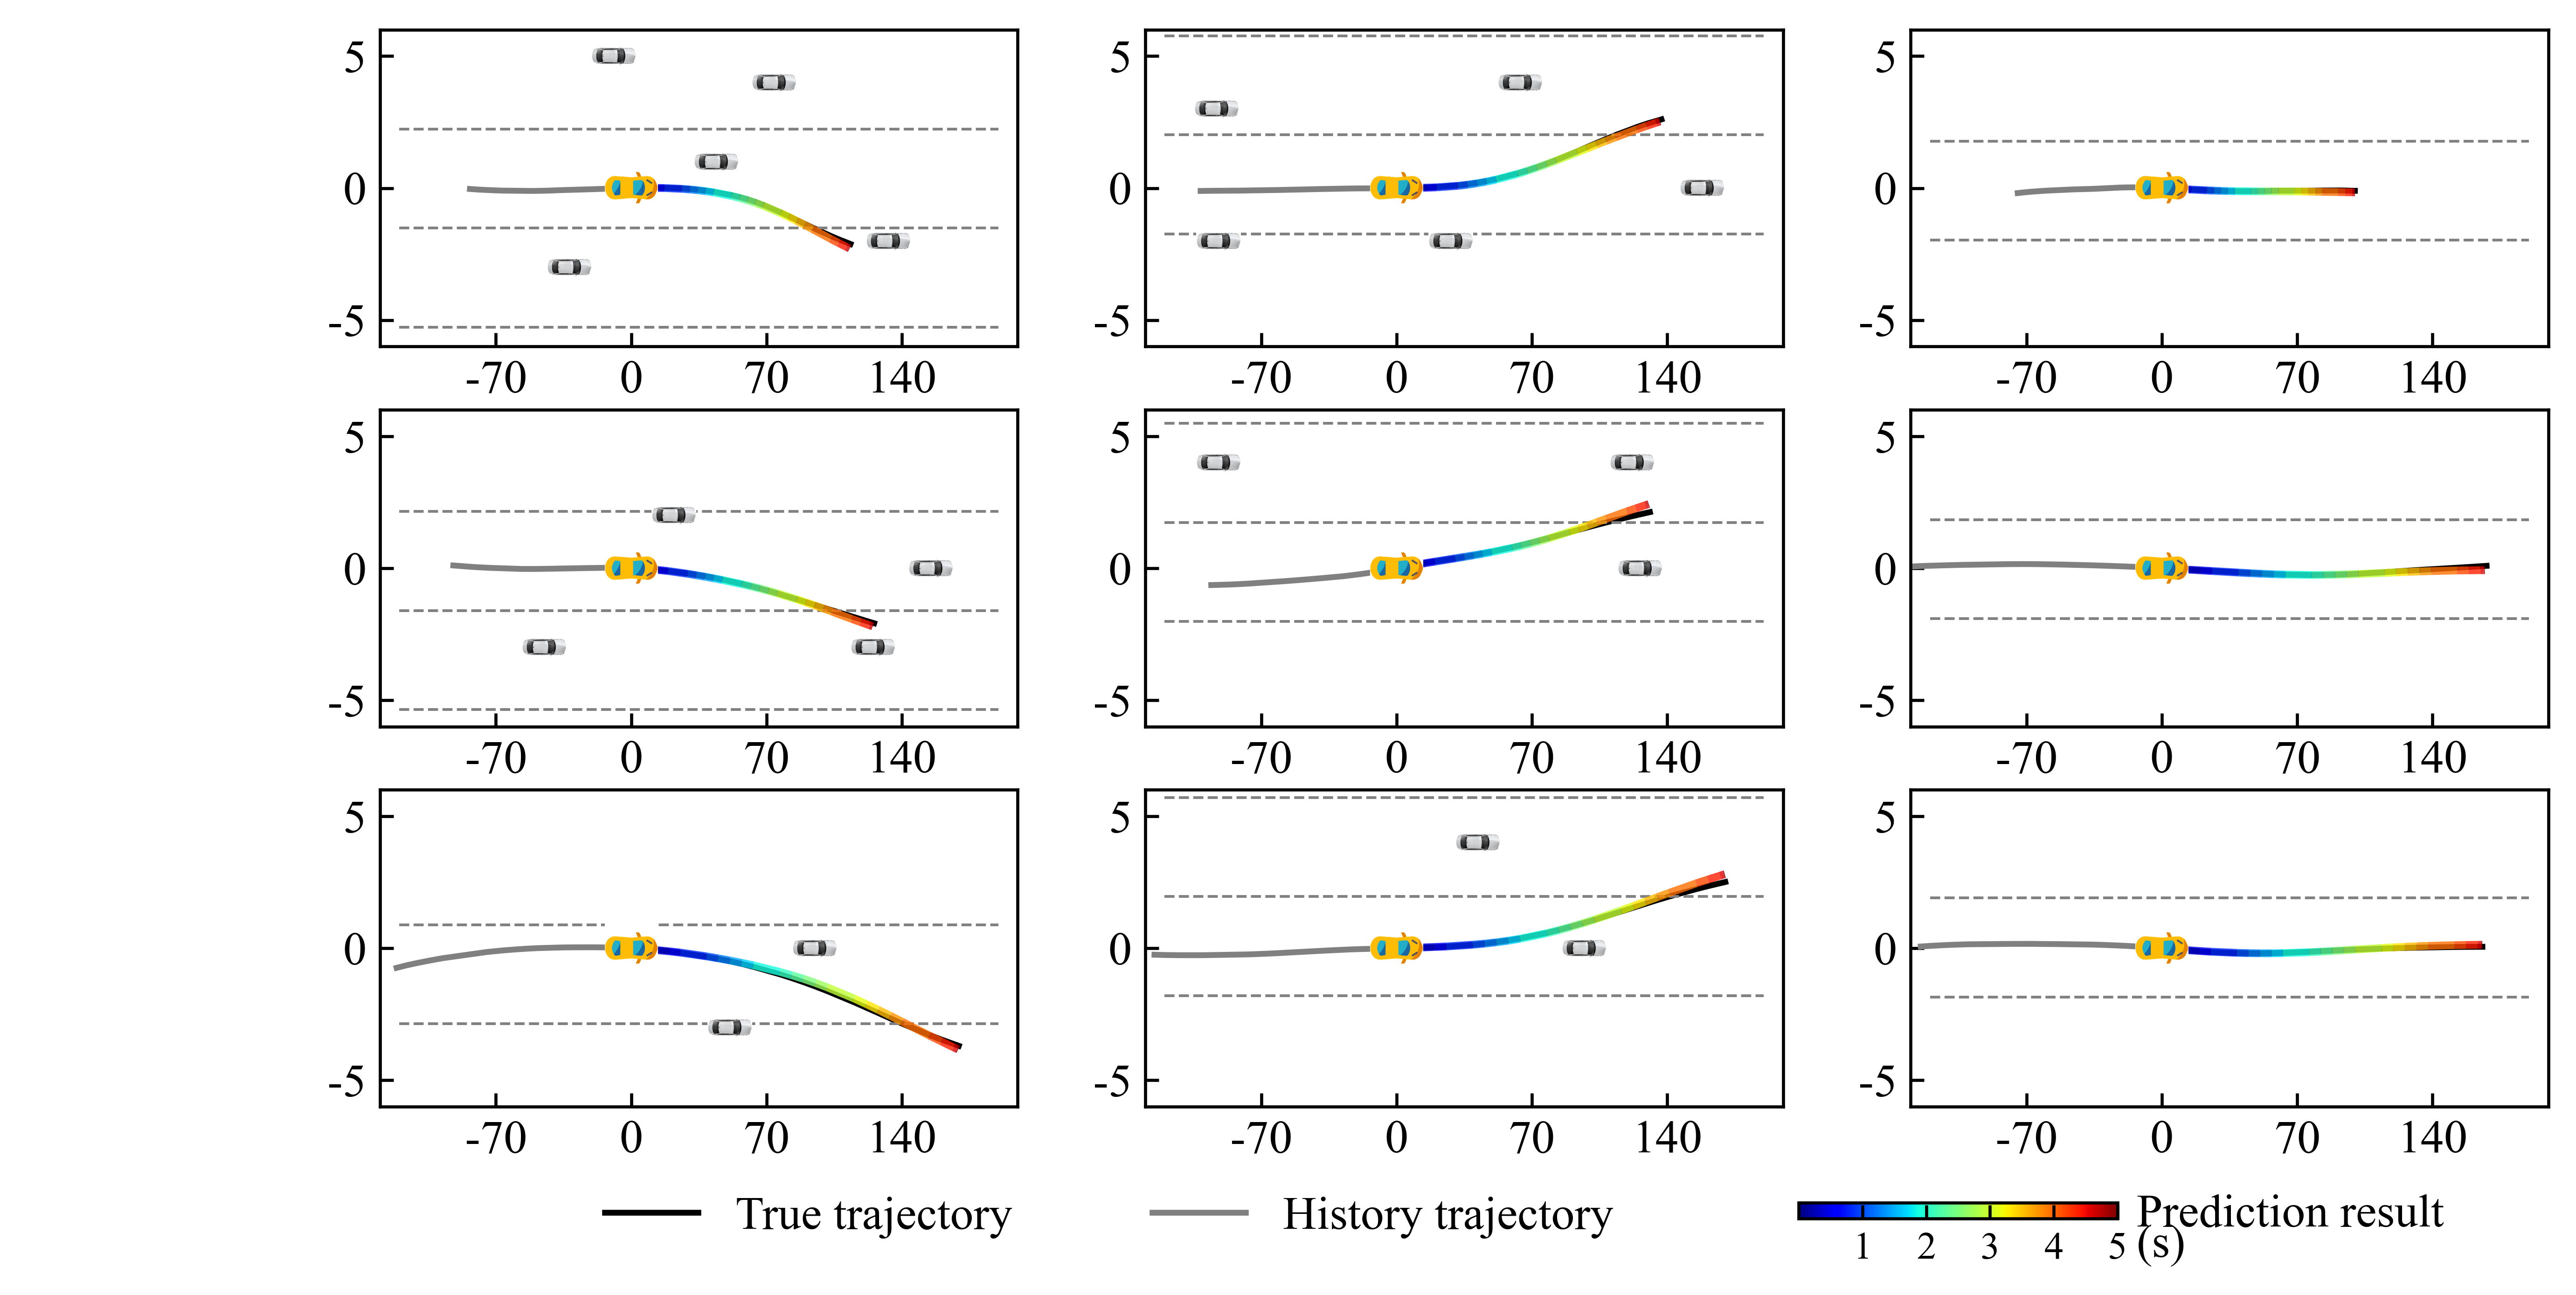

In [220]:
tv_img=plt.imread('E:/Fig/target vehicle.png')
sv_img=plt.imread('E:/Fig/sv.png')
sv_im=OffsetImage(sv_img,zoom=0.06)
tv_im=OffsetImage(tv_img,zoom=0.08)
true_array=np.zeros_like(traj_testlabel)
predict_array=np.zeros_like(pre)

for i in range(len(predict_array)):
    true_array[i]=traj_testlabel[i]
    predict_array[i]=pre[i]
def draw_car(ori_testdata,true_array,ax,tv_im,sv_im):
    tv_ab=AnnotationBbox(tv_im,(0,0),frameon=False)
    ax.add_artist(tv_ab)
    pd_x=[]
    pd_y=[]
    lp_x=[]
    lp_y=[]
    rp_x=[]
    rp_y=[]
    lf_x=[]
    lf_y=[]
    rf_x=[]
    rf_y=[]
    for j in range(arg['input_length']):
        pd_x.append(ori_testdata[j,16])
        pd_y.append(-ori_testdata[j,6])
        lp_x.append(ori_testdata[j,17])
        lp_y.append(-ori_testdata[j,7])
        rp_x.append(ori_testdata[j,18])
        rp_y.append(-ori_testdata[j,8])
        lf_x.append(ori_testdata[j,19])
        lf_y.append(-ori_testdata[j,9])
        rf_x.append(ori_testdata[j,20])
        rf_y.append(-ori_testdata[j,10])
    if -600<ori_testdata[arg['input_length']-1,6]<600:
        pd_ab=AnnotationBbox(sv_im,(-ori_testdata[arg['input_length']-1,6],ori_testdata[arg['input_length']-1,16]),frameon=False)
        ax.add_artist(pd_ab)
    if -600<ori_testdata[arg['input_length']-1,7]<600:     
        lp_ab=AnnotationBbox(sv_im,(-ori_testdata[arg['input_length']-1,7],ori_testdata[arg['input_length']-1,17]),frameon=False)
        ax.add_artist(lp_ab)
    if -600<ori_testdata[arg['input_length']-1,8]<600:     
        rp_ab=AnnotationBbox(sv_im,(-ori_testdata[arg['input_length']-1,8],ori_testdata[arg['input_length']-1,18]),frameon=False)
        ax.add_artist(rp_ab)
    if -600<ori_testdata[arg['input_length']-1,9]<600:     
        lf_ab=AnnotationBbox(sv_im,(-ori_testdata[arg['input_length']-1,9],ori_testdata[arg['input_length']-1,19]),frameon=False)
        ax.add_artist(lf_ab)
    if -600<ori_testdata[arg['input_length']-1,10]<600:     
        rf_ab=AnnotationBbox(sv_im,(-ori_testdata[arg['input_length']-1,10],ori_testdata[arg['input_length']-1,20]),frameon=False)
        ax.add_artist(rf_ab)

def plot_hline(true_array,ax1_value,lc_type):
    if lc_type=='LK':
        plt.hlines(-true_array[ax1_value,19,0]+1.875,xmin=-120,xmax=190,ls='--',lw=0.7,color='grey')
        plt.hlines(-true_array[ax1_value,19,0]-1.875,xmin=-120,xmax=190,ls='--',lw=0.7,color='grey')
    else:    
        plt.hlines(-true_array[ax1_value,19,0],xmin=-120,xmax=190,ls='--',lw=0.7,color='grey')
        plt.hlines(-true_array[ax1_value,19,0]+3.75,xmin=-120,xmax=190,ls='--',lw=0.7,color='grey')
        plt.hlines(-true_array[ax1_value,19,0]-3.75,xmin=-120,xmax=190,ls='--',lw=0.7,color='grey')

def plot_trajectory(true_array,predict_array,ori_testdata,ax_value,ax,tv_im,sv_im,lc_type,cbar=False,y_max=6,y_min=-6,x_min=-130,x_max=200,hist_ls='-',hist_ms=2):
    ax.plot(true_array[ax_value,:,1],-true_array[ax_value,:,0],'-',markerfacecolor='white',label="True trajectory",c="black",ms=hist_ms)
    lc=colorline(predict_array[ax_value,:,1],-predict_array[ax_value,:,0],ax)
    ax.plot(ori_testdata[ax_value,:,1],-ori_testdata[ax_value,:,0],hist_ls,label="History trajectory",markerfacecolor='white',
                  ms=hist_ms,c='grey')
    plot_hline(true_array,ax_value,lc_type)
    draw_car(ori_testdata[ax_value],true_array[ax_value],ax,tv_im,sv_im)
    ax.set_xbound(x_min,x_max)
    ax.set_ybound(y_min,y_max)
    ax.xaxis.set_major_locator(MultipleLocator(70))
    x1_label=ax.get_xticklabels() 
    [x1_label_temp.set_fontname('Times New Roman') for x1_label_temp in x1_label]
    y1_label = ax.get_yticklabels() 
    [y1_label_temp.set_fontname('Times New Roman') for y1_label_temp in y1_label]

ax1_value=3
ax4_value=8
ax7_value=11

ax2_value=310
ax5_value=399
ax8_value=387

ax3_value=587
ax6_value=615
ax9_value=604
fig=plt.figure(figsize=(10,5), dpi=600)
plt.figure(1)

ax1=plt.subplot2grid((3, 3),                        
                       (0, 0))

plot_trajectory(true_array,predict_array,ori_testdata,ax1_value,ax1,tv_im,sv_im,lc_type='RLC')

ax4=plt.subplot2grid((3, 3),                        
                       (1, 0))
plot_trajectory(true_array,predict_array,ori_testdata,ax4_value,ax4,tv_im,sv_im,lc_type='RLC')
ax7=plt.subplot2grid((3, 3),                        
                       (2, 0))
plot_trajectory(true_array,predict_array,ori_testdata,ax7_value,ax7,tv_im,sv_im,lc_type='RLC')

##LLC
ax2=plt.subplot2grid((3, 3),                         
                       (0, 1))
plot_trajectory(true_array,predict_array,ori_testdata,ax2_value,ax2,tv_im,sv_im,lc_type='LLC')


ax5=plt.subplot2grid((3, 3),                        
                       (1, 1))
plot_trajectory(true_array,predict_array,ori_testdata,ax5_value,ax5,tv_im,sv_im,lc_type='LLC')

ax8=plt.subplot2grid((3, 3),                         
                       (2, 1))
plot_trajectory(true_array,predict_array,ori_testdata,ax8_value,ax8,tv_im,sv_im,lc_type='LLC')

#不换道
ax3=plt.subplot2grid((3, 3),                         
                       (0, 2))
plot_trajectory(true_array,predict_array,ori_testdata,ax3_value,ax3,tv_im,sv_im,lc_type='LK')

ax6=plt.subplot2grid((3, 3),                         
                       (1, 2))
plot_trajectory(true_array,predict_array,ori_testdata,ax6_value,ax6,tv_im,sv_im,lc_type='LK')

ax9=plt.subplot2grid((3, 3),                         
                       (2, 2))
plot_trajectory(true_array,predict_array,ori_testdata,ax9_value,ax9,tv_im,sv_im,lc_type='LK')
plt.legend(bbox_to_anchor=(-0.4,-0.15),ncols=2,frameon=False,columnspacing=3)
cmap1 = plt.get_cmap('jet')
norm1 = plt.Normalize(vmin=0, vmax=5)
im1 = plt.cm.ScalarMappable(norm=norm1, cmap=cmap1)
axins = inset_axes(plt.gca(), width="50%",  height="5%", loc='lower left',borderpad=-2.4)
ticks = [1, 2, 3, 4, 5]
cb = fig.colorbar(im1,cax=axins,orientation='horizontal')
cb.ax.tick_params(labelsize=10)
cb.set_ticks(ticks)
plt.text(5.3,-0.5,s='Prediction result',fontproperties = 'Times New Roman')
plt.text(5.3,-2.4,s='(s)',fontproperties = 'Times New Roman')
plt.savefig('E:/STIL-IE/fig/Fig12.png',dpi=600,bbox_inches='tight')
plt.show()

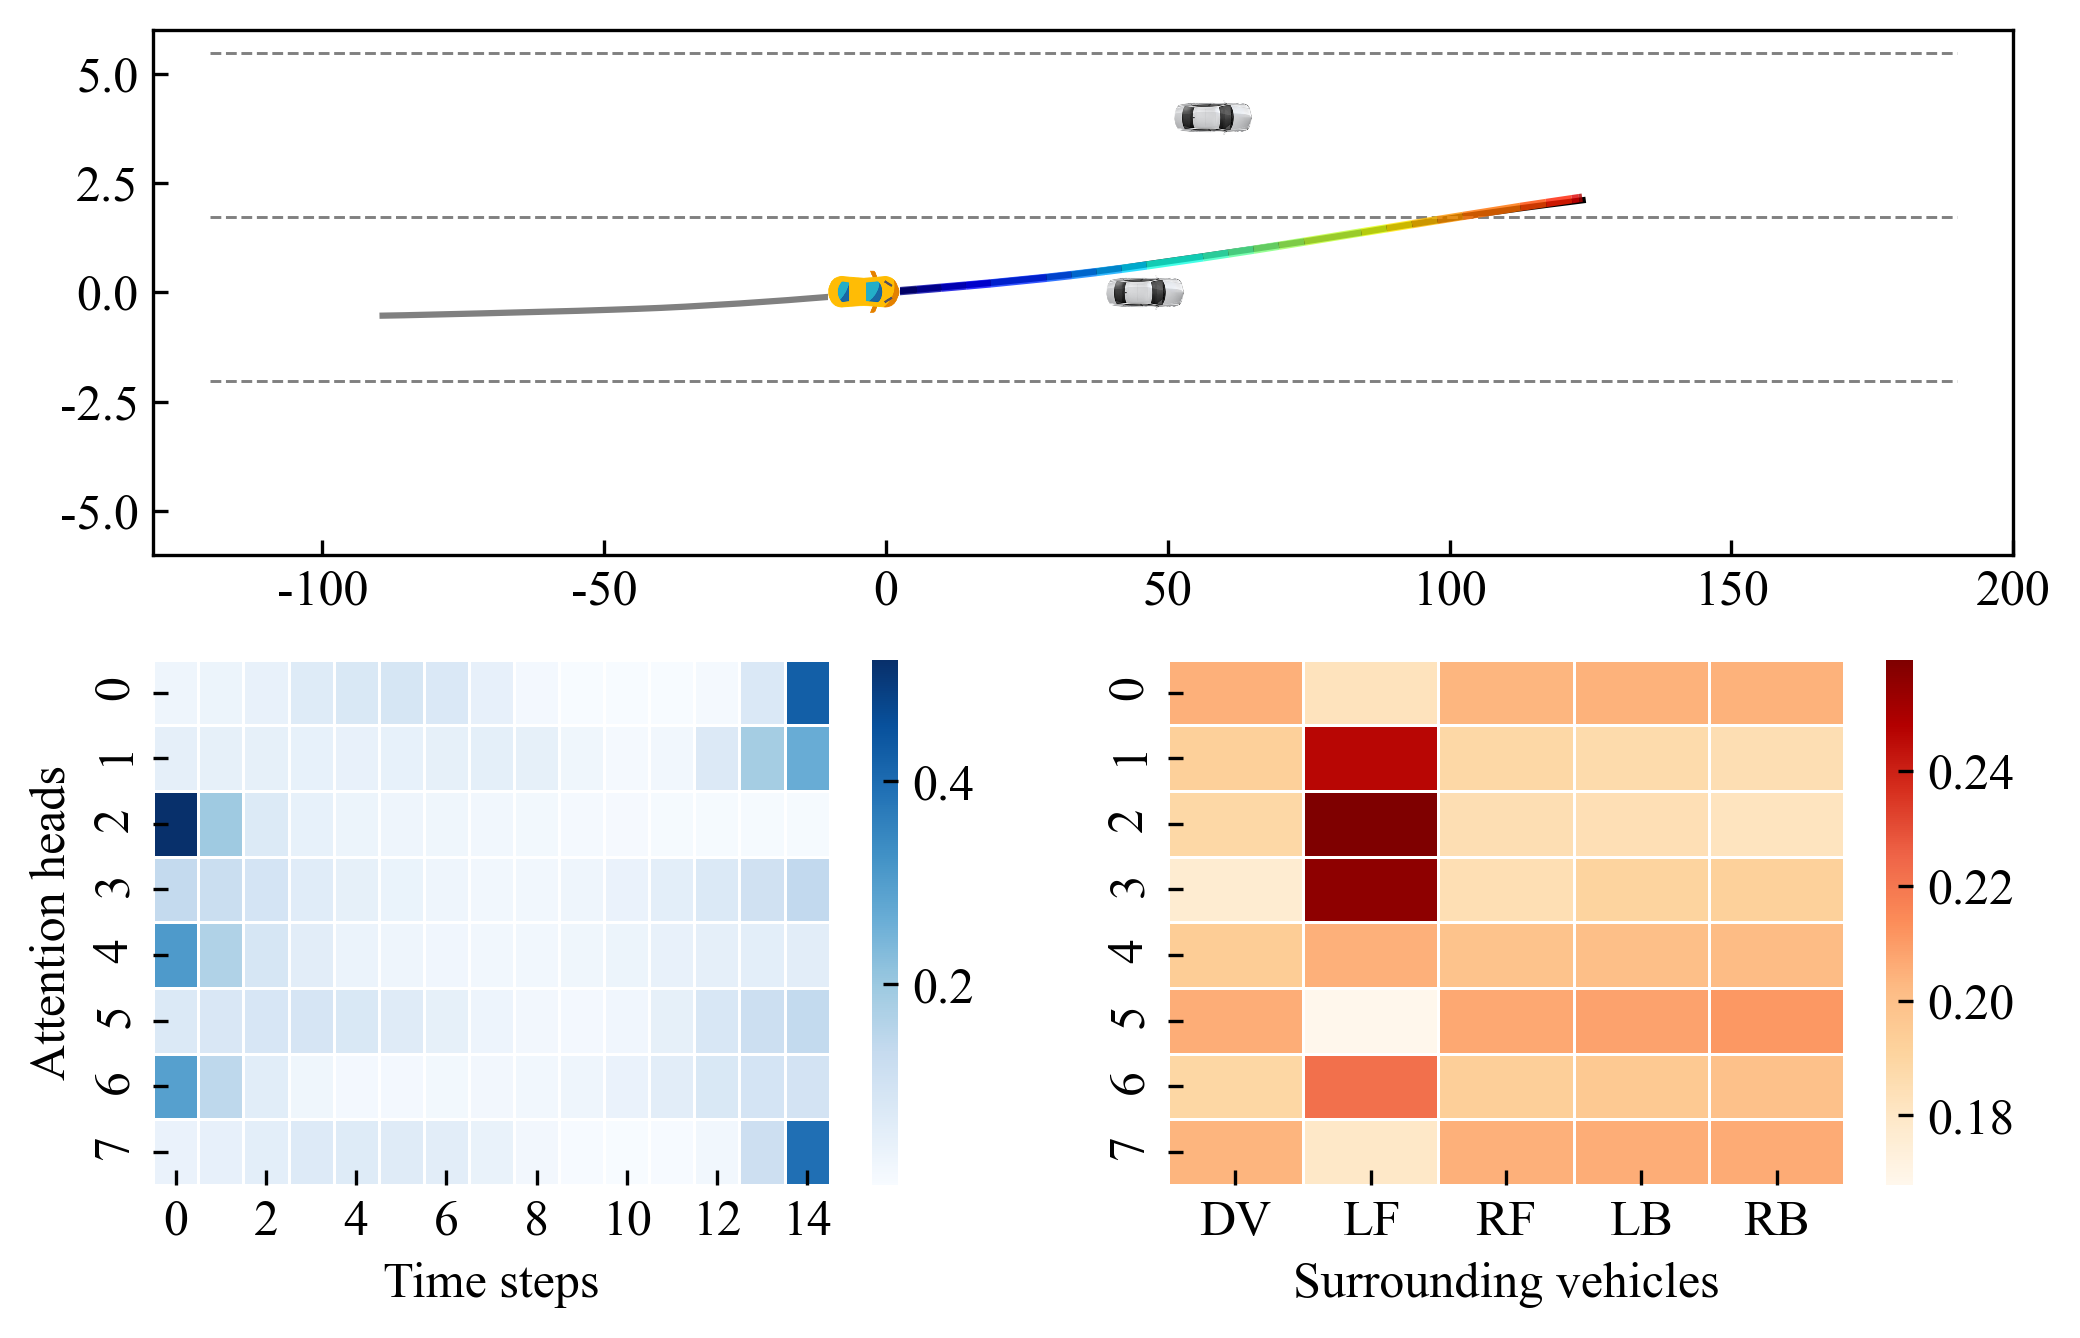

In [14]:
sv_im=OffsetImage(sv_img,zoom=0.1)
tv_im=OffsetImage(tv_img,zoom=0.1)
#sv plot parameter set
hist_cmp='grey'
hist_ls='-'
hist_ms=3
# k=[14,16,32,63,211,301]
# for k in range(traj_testlabel.shape[0]):
k=301
plt.figure(figsize=(8,5), dpi=300)
plt.figure(1)
true_array=traj_testlabel[k]
predict_array=pre[k,:,:]
# 设置轴标题字体大小
ax1=plt.subplot2grid((2, 2),                         # 将整个图像窗口分成3行3列
                       (0, 0),                         # 从第0行第0列开始作图，即索引从0开始
                       colspan=2)

plt.ylim(-6,6)
plt.xlim(-130,200)
ax1.plot(true_array[:,1],-true_array[:,0],'-',markerfacecolor='white',label="true trajectory",c="black",ms=hist_ms)
# ax1.plot(predict_array[:,1],-predict_array[:,0],'o',markerfacecolor='white',label="预测轨迹",c='red', ms=hist_ms)
lc=colorline(predict_array[:,1],-predict_array[:,0],ax1)
ax1.plot(ori_testdata[k,:,1],-ori_testdata[k,:,0],hist_ls,label="history trajectory",markerfacecolor='white',
              ms=hist_ms,c=hist_cmp)
tv_ab=AnnotationBbox(tv_im,(-4,0),frameon=False)
ax1.add_artist(tv_ab)
ax1.hlines(-true_array[19,0],xmin=-120,xmax=190,ls='--',lw=0.7,color='grey')
ax1.hlines(-true_array[19,0]+3.75,xmin=-120,xmax=190,ls='--',lw=0.7,color='grey')
ax1.hlines(-true_array[19,0]-3.75,xmin=-120,xmax=190,ls='--',lw=0.7,color='grey')
pd_x=[]
pd_y=[]
lp_x=[]
lp_y=[]
rp_x=[]
rp_y=[]
lf_x=[]
lf_y=[]
rf_x=[]
rf_y=[]
for j in range(arg['input_length']):
    pd_x.append(ori_testdata[k,j,16])
    pd_y.append(-ori_testdata[k,j,6])
    lp_x.append(ori_testdata[k,j,17])
    lp_y.append(-ori_testdata[k,j,7])
    rp_x.append(ori_testdata[k,j,18])
    rp_y.append(-ori_testdata[k,j,8])
    lf_x.append(ori_testdata[k,j,19])
    lf_y.append(-ori_testdata[k,j,9])
    rf_x.append(ori_testdata[k,j,20])
    rf_y.append(-ori_testdata[k,j,10])
if -600<ori_testdata[k,arg['input_length']-1,6]<600:
    pd_ab=AnnotationBbox(sv_im,(-ori_testdata[k,arg['input_length']-1,6],ori_testdata[k,arg['input_length']-1,16]),frameon=False)
    ax1.add_artist(pd_ab)


if -600<ori_testdata[k,arg['input_length']-1,7]<600:     
    lp_ab=AnnotationBbox(sv_im,(-ori_testdata[k,arg['input_length']-1,7],ori_testdata[k,arg['input_length']-1,17]),frameon=False)
    ax1.add_artist(lp_ab)


if -600<ori_testdata[k,arg['input_length']-1,8]<600:     
    rp_ab=AnnotationBbox(sv_im,(-ori_testdata[k,arg['input_length']-1,8],ori_testdata[k,arg['input_length']-1,18]),frameon=False)
    ax1.add_artist(rp_ab)


if -600<ori_testdata[k,arg['input_length']-1,9]<600:     
    lf_ab=AnnotationBbox(sv_im,(-ori_testdata[k,arg['input_length']-1,9],ori_testdata[k,arg['input_length']-1,19]),frameon=False)
    ax1.add_artist(lf_ab)


if -600<ori_testdata[k,arg['input_length']-1,10]<600:     
    rf_ab=AnnotationBbox(sv_im,(-ori_testdata[k,arg['input_length']-1,10],ori_testdata[k,arg['input_length']-1,20]),frameon=False)
    ax1.add_artist(rf_ab)


plt.xticks(fontproperties = 'Times New Roman')
plt.yticks(fontproperties = 'Times New Roman')
layers={}
layers['input_2 ']= 'attention_mask_matrics'
layers['layer_temporal ']= 'multi_head_attention_1'
layers['layer_spatial ']= 'multi_head_attention'
func_spatial = K.function([model.get_layer(index=0).input,model.get_layer(layers['input_2 ']).input], model.get_layer(layers['layer_spatial ']).output)
func_temporal = K.function([model.get_layer(index=0).input,model.get_layer(layers['input_2 ']).input], model.get_layer(layers['layer_temporal ']).output)
layerOutput_spatial,weights_spatial= func_spatial([testdata,adjacen_testdata])  # input_data is a numpy array
layerOutput_temporal,weights_temporal= func_temporal([testdata,adjacen_testdata])  # input_data is a numpy array
sum_weights=tf.reduce_mean(weights_temporal,axis=2)
sum_weights_spatial=tf.reduce_mean(weights_spatial,axis=2)
ax2=plt.subplot2grid((2, 2),                         # 
                       (1, 0))

TI_weights=sns.heatmap(sum_weights[k], annot=False, ax=ax2,cmap='Blues',cbar=True,linewidths=0.25,annot_kws={'fontsyle':'normal'})
plt.xlabel('Time steps',fontproperties = 'Times New Roman') #
plt.ylabel('Attention heads',fontproperties = 'Times New Roman') #y
plt.xticks(fontproperties = 'Times New Roman')
plt.yticks(fontproperties = 'Times New Roman')
ax3=plt.subplot2grid((2, 2),                         #
                       (1, 1))
x_ticklabels=['DV','LF','RF','LB','RB']
#     y_ticklabels=['x','y','v_x','v_y','a_x','a_y']
SI_weights=sns.heatmap(sum_weights_spatial[k], annot=False, ax=ax3,cmap='OrRd',cbar=True,xticklabels=x_ticklabels,linewidths=0.25
                       )
plt.xticks(fontproperties = 'Times New Roman')
plt.yticks(fontproperties = 'Times New Roman')
plt.xlabel('Surrounding vehicles',fontproperties = 'Times New Roman') #
#     plt.ylabel('Attention heads',fontproperties = 'Times New Roman') 
# cb = fig.colorbar(lc, cmap=plt.get_cmap('rainbow'))
# cb.set_label('Prediction result(s)',fontproperties = 'Times New Roman')
#     plt.show()
plt.savefig('E:/STIL-IE/fig/visualize%d.png'%k,bbox_inches='tight',dpi=600)

C:\Users\lxhms\AppData\Local\Temp\ipykernel_34012\1118537227.py:31: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  names['ax_%d'%i]=plt.subplot2grid((2, 8),                         # 将整个图像窗口分成2行8列
C:\Users\lxhms\AppData\Local\Temp\ipykernel_34012\1118537227.py:43: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  names['ax_%d'%i]=plt.subplot2grid((2, 8),                         # 将整个图像窗口分成3行3列


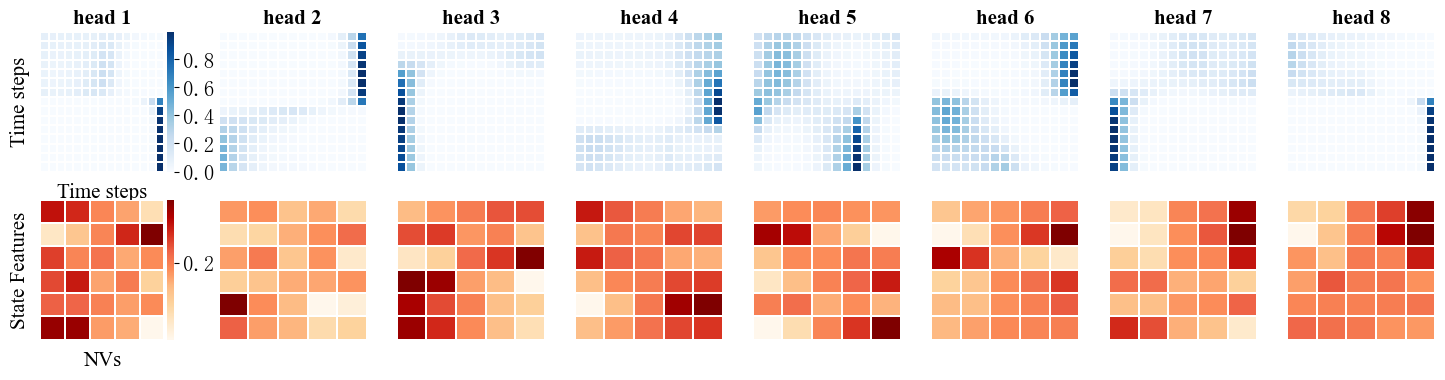

In [8]:
from matplotlib.patches import ConnectionPatch
from matplotlib.colors import LinearSegmentedColormap, ListedColormap
font_size=15
scales=0.3048
config_traj = {
    "font.family":'serif',
    "font.size": font_size,
    "mathtext.fontset":'stix',
    "font.serif": ['SimSun'],
    'xtick.direction':'out',
    'ytick.direction':'out'
}
k=4
plt.rcParams['axes.unicode_minus']=False
plt.rcParams.update(config_traj)
layers={}
layers['input_2 ']= 'attention_mask_matrics'
layers['layer_temporal ']= 'multi_head_attention_1'
layers['layer_spatial ']= 'multi_head_attention'
func_spatial = K.function([model.get_layer(index=0).input,model.get_layer(layers['input_2 ']).input], model.get_layer(layers['layer_spatial ']).output)
func_temporal = K.function([model.get_layer(index=0).input,model.get_layer(layers['input_2 ']).input], model.get_layer(layers['layer_temporal ']).output)
layerOutput_spatial,weights_spatial= func_spatial([testdata,adjacen_testdata])  # input_data is a numpy array
layerOutput_temporal,weights_temporal= func_temporal([testdata,adjacen_testdata])  # input_data is a numpy array
# sum_weights=tf.reduce_mean(weights_temporal,axis=2)
# sum_weights_spatial=tf.reduce_mean(weights_spatial,axis=2)
x_ticklabels=[]
y_ticklabels=[]
fig,ax=plt.subplots(2,8,figsize=(18, 4))
names = locals()
for i in range(8):
    names['ax_%d'%i]=plt.subplot2grid((2, 8),                         
                       (0, i))
    if i !=0:
         sns.heatmap(weights_temporal[k,i], annot=False, ax=names['ax_%d'%i],cmap='Blues',cbar=False,xticklabels=x_ticklabels,yticklabels=y_ticklabels,linewidths=0.25)
    else:
         sns.heatmap(weights_temporal[k,i], annot=False, ax=names['ax_%d'%i],cmap='Blues',cbar=True,xticklabels=x_ticklabels,yticklabels=y_ticklabels,linewidths=0.25,cbar_kws = {'format':'%.1f',
                  'pad':0.015,'ticks':np.arange(0,1,0.2)})
         names['ax_%d'%i].set_xlabel('Time steps',fontproperties = 'Times New Roman')
#          names['ax_%d'%i].tick_params(labelsize=2)   
         names['ax_%d'%i].set_ylabel('Time steps',fontproperties = 'Times New Roman')
    plt.title('head %d'%(i+1),fontproperties = 'Times New Roman',fontweight='heavy')
for i in range(8):
    names['ax_%d'%i]=plt.subplot2grid((2, 8),                       
                       (1, i))
    if i !=0:
        sns.heatmap(weights_spatial[k,i], annot=False, ax=names['ax_%d'%i],cmap='OrRd',cbar=False,xticklabels=x_ticklabels,yticklabels=y_ticklabels,linewidths=0.25)
    else:
        sns.heatmap(weights_spatial[k,i], annot=False, ax=names['ax_%d'%i],cmap='OrRd',cbar=True,xticklabels=x_ticklabels,yticklabels=y_ticklabels,linewidths=0.25,cbar_kws = {'format':'%.1f',
                  'pad':0.015,'ticks':np.arange(0,2,0.1)})
        names['ax_%d'%i].set_xlabel('NVs',fontproperties = 'Times New Roman')
#          names['ax_%d'%i].tick_params(labelsize=2)   
        names['ax_%d'%i].set_ylabel('State Features',fontproperties = 'Times New Roman') 
    #     sns.heatmap(weights_spatial[k,i], annot=False, ax=names['ax_%d'%i],cmap='OrRd',cbar=True,xticklabels=x_ticklabels,yticklabels=y_ticklabels,linewidths=0.25)
# plt.text(-40,-3,s='TI',fontproperties = 'Times New Roman')
# plt.text(-40,3,s='SI',fontproperties = 'Times New Roman')

# plt.tight_layout()
# plt.xlabel('周围车辆编号') #x轴label的文本和字体大小
# plt.ylabel('注意力头部') #y轴label的文本和字体大小
fig.savefig('E:/STIL-IE/Fig11.png',dpi=600,bbox_inches='tight')

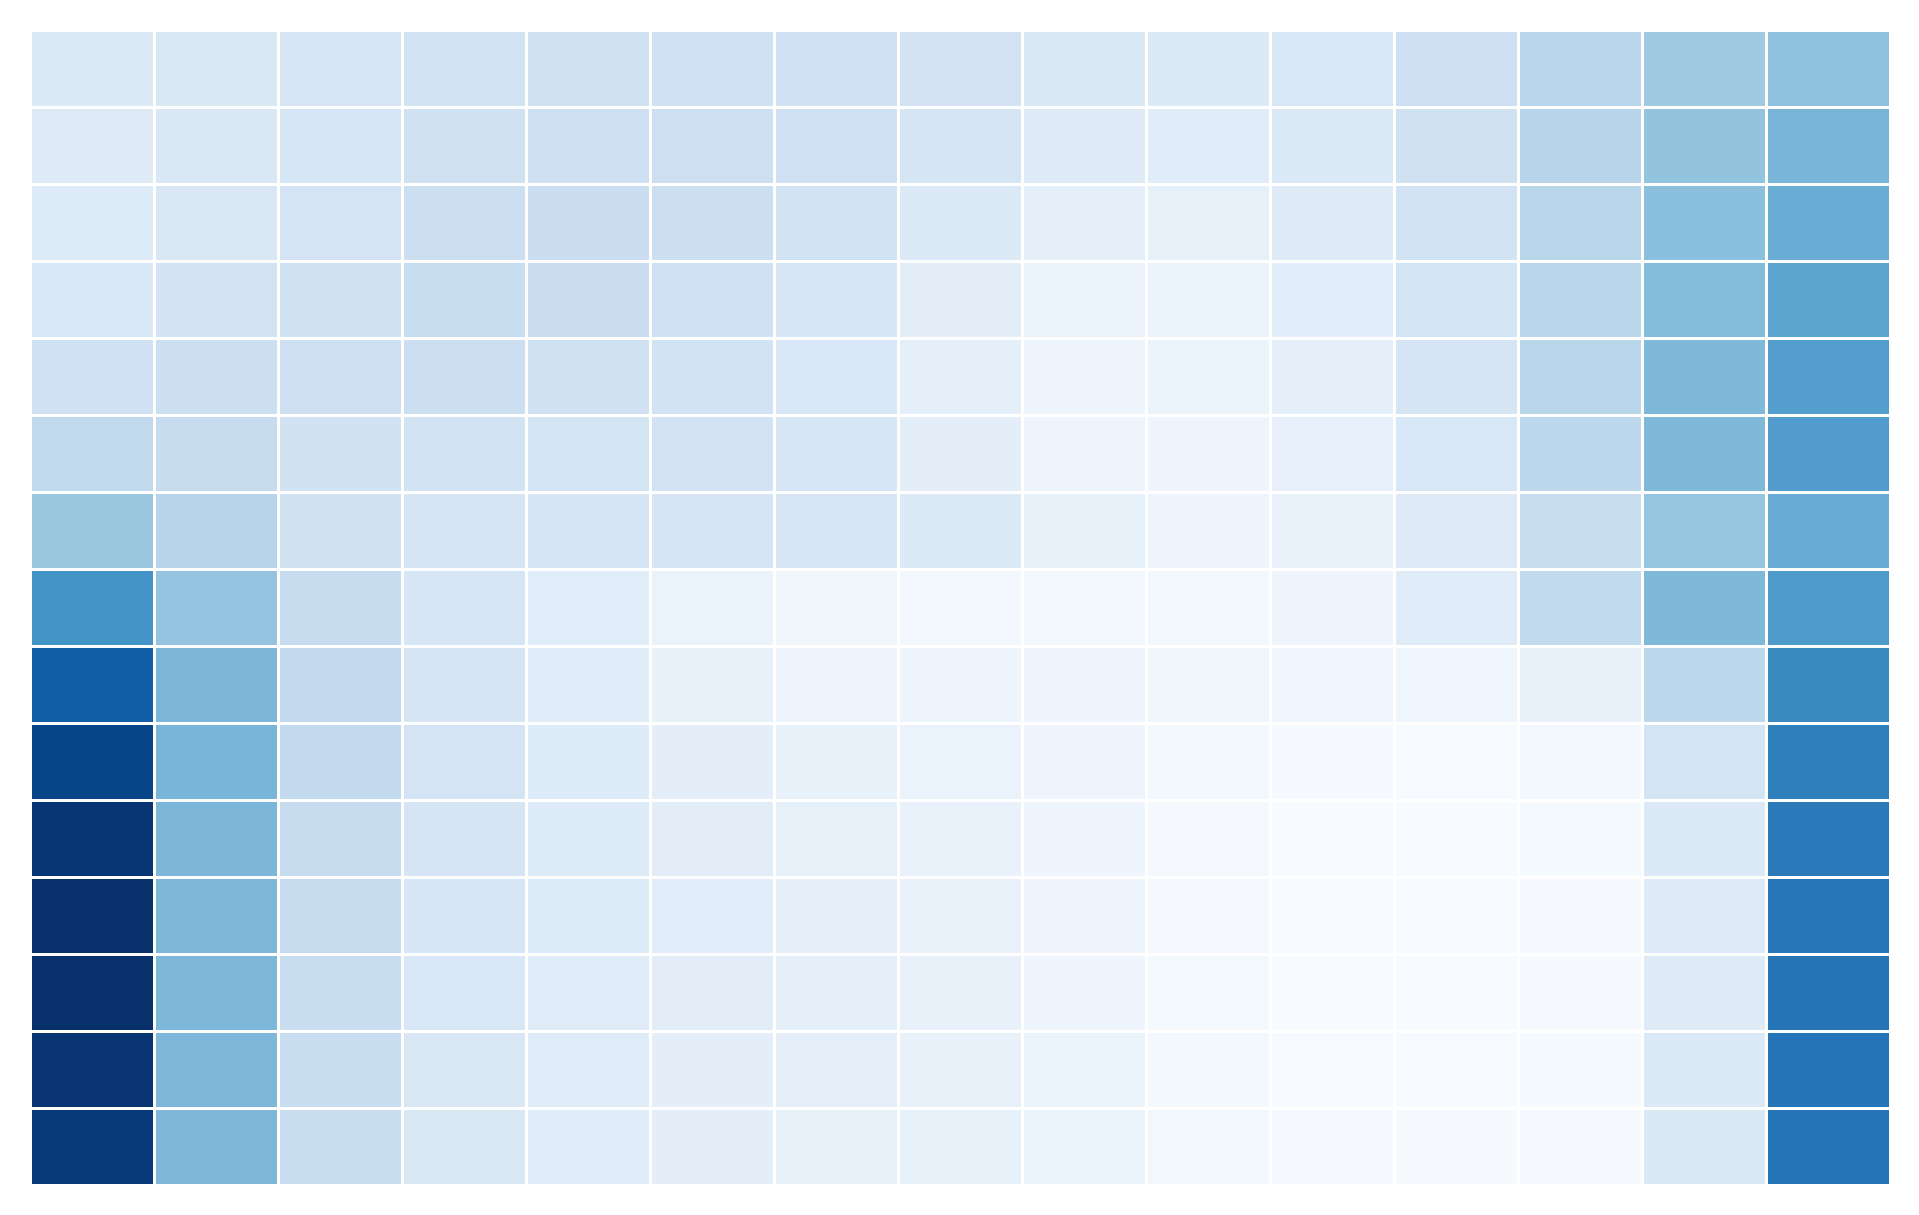

In [14]:

# k=[14,16,211,301]
k=301

plt.figure(figsize=(8,5), dpi=300)
plt.figure(1)
# plt.figure(figsize=(6,3),dpi=600)
true_array=traj_testlabel[k]
true_array=true_array*scales
predict_array=pre[k,:,:]
predict_array=predict_array*scales  

layers={}
layers['input_2 ']= 'attention_mask_matrics'
layers['layer_temporal ']= 'multi_head_attention_1'
layers['layer_spatial ']= 'multi_head_attention'
func_spatial = K.function([model.get_layer(index=0).input,model.get_layer(layers['input_2 ']).input], model.get_layer(layers['layer_spatial ']).output)
func_temporal = K.function([model.get_layer(index=0).input,model.get_layer(layers['input_2 ']).input], model.get_layer(layers['layer_temporal ']).output)
layerOutput_spatial,weights_spatial= func_spatial([testdata,adjacen_testdata])  # input_data is a numpy array
layerOutput_temporal,weights_temporal= func_temporal([testdata,adjacen_testdata])  # input_data is a numpy array
sum_weights=tf.reduce_mean(weights_temporal,axis=1)
sum_weights_spatial=tf.reduce_mean(weights_spatial,axis=1)
x_ticklabels=[]
y_ticklabels=[]
#设置色条的刻度：
tick_=np.arange(0,1,0.1).astype(float)

#编辑做为参数的字典：
TI_weights=sns.heatmap(sum_weights[k], annot=False,cmap='Blues',cbar=False,linewidths=0.25,annot_kws={'fontsyle':'normal'},xticklabels=x_ticklabels,yticklabels=y_ticklabels)
# plt.xticks(fontproperties = 'Times New Roman')
# plt.yticks(fontproperties = 'Times New Roman')
# SI_weights=sns.heatmap(sum_weights_spatial[k], annot=False ,cmap='OrRd',cbar=False,
#                        linewidths=0.25,xticklabels=x_ticklabels,yticklabels=y_ticklabels)
plt.xticks(fontproperties = 'Times New Roman')
plt.yticks(fontproperties = 'Times New Roman')
# plt.xlabel('Surrounding vehicles',fontproperties = 'Times New Roman')
# plt.ylabel('Attention heads',fontproperties = 'Times New Roman') 
plt.savefig('E:/STIL-IE//Fig/temporal%d.png'%k,bbox_inches='tight',dpi=600)

In [7]:
weights_temporal.shape

(627, 8, 15, 15)